# Lab-9: Convolutions and CNN

In this lab, you will practice convolutional operation and how to implement CNN using keras and tensorflow.


## Objectives:

1. Convolutions - application examples:
    - edge detection    
    - negation
    - blurring
    - sharpening
2. Building CNN in PyTorch / Keras / Tensorflow
    - example CNN
    - comparing with Fully-connected NN

### Recap

1. What is the use of convolutions? (In general) <span style="color:yellow"> Image and signal processing, computer vision, probability theory, etc.
2. Why use convolutional layers instead of fully-connected ones? <span style="color:yellow"> **Weight Sharing**: Convolutional layers have less weights and therefore use less memory and run faster.  In fact, a fully connected layer is the same as a convolutional layer with a kernel size equal to the dimensions of the image. That’s a huge window (by orders of magnitude) compared to the typical 3x3xN kernel size used in typical convolutional neural networks. **Location Invariance**: Let’s say you want to classify whether or not there’s an elephant in an image. Because you are sliding your filters over the whole image you don’t really care where the elephant occurs. In practice, pooling also gives you invariance to translation, rotation and scaling. **Compositionality**: Each filter composes a local patch of lower-level features into higher-level representation. That’s why CNNs are so powerful in Computer Vision. It makes intuitive sense that you build edges from pixels, shapes from edges, and more complex objects from shapes.
Must read section 9.2 in: https://www.deeplearningbook.org/contents/convnets.html

## Convolutions
Let's upload some image (you can try your own image changing the url)

In [27]:
import urllib.request
url = "https://res-2.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/lss423kothpqpjpwbzg0"
filename = 'grid_img.jpg'
urllib.request.urlretrieve(url, filename)

('grid_img.jpg', <http.client.HTTPMessage at 0x7fa225007730>)

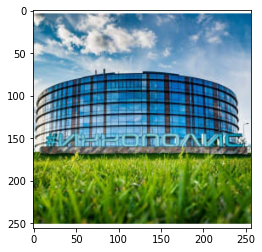

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy import ndimage

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
import numpy as np

# Let's read and plot the image
image = plt.imread('grid_img.jpg')
plt.imshow(image)

original img shape:  (256, 256, 3)
grayscale img shape (256, 256)


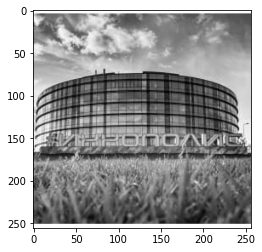

In [73]:
gray_image = rgb2gray(image)
plt.imshow(gray_image * 100, cmap='gray')
print("original img shape: ", image.shape)
print("grayscale img shape", gray_image.shape)

[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]] is a kernel for detecting horizontal edges
[[-1  0  1]
 [-1  0  1]
 [-1  0  1]] is a kernel for detecting vertical edges


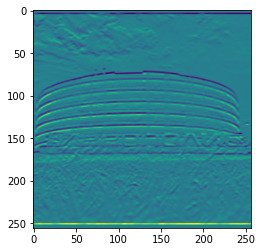

In [74]:
# first, let's define edge-detecting filters
horizontal_kernel = np.array([[1, 1, 1], 
                              [0, 0, 0], 
                              [-1, -1, -1]])
print(horizontal_kernel, 'is a kernel for detecting horizontal edges')
 
vertical_kernel = np.array([[-1, 0, 1], 
                            [-1, 0, 1], 
                            [-1, 0, 1]])
print(vertical_kernel, 'is a kernel for detecting vertical edges')

out_h = ndimage.convolve(gray_image, horizontal_kernel, mode='reflect')
out_v = ndimage.convolve(gray_image, vertical_kernel, mode='reflect')
plt.imshow(out_h)
#plt.imshow(out_v)

Let's apply different types of convolutions on this image. Complete the following function.

Take care of dimensions - the resuting image should be of the same size.
Hint:

![alt text](https://i.gyazo.com/5265866b07235dfa181de39913e94713.png)

Horizontal kernel applied


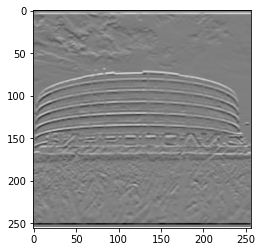

In [75]:
# apply kernel on input image such that the image size is preserved
def convolve(img, kernel):
        w, h = img.shape[0], img.shape[1]
        f = kernel.shape[0]
        if (f - 1) % 2 !=0 :
            print("failure to choose apt padding, choose another filter size!")
        padding = (f - 1)//2
        padded_img = np.lib.pad(img, ((padding, padding), (padding, padding)), 'constant', constant_values = ((0,0),(0,0)))
        result = np.zeros(img.shape)
        for i in range(h):
            for j in range(w):
                # we chose padding size such that when sliding through the padded image
                # with the kernel we obtain exactly same dimensionality (w x h)
                result[i,j] = np.sum(padded_img[i:i + f, j:j+f] * kernel)                 
        return result

c = convolve(gray_image, horizontal_kernel)
print("Horizontal kernel applied")
plt.imshow(c, cmap='gray')

Vertical kernel applied


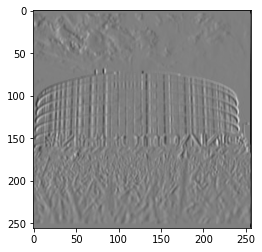

In [76]:
c = convolve(gray_image, vertical_kernel)
print("Vertical kernel applied")
plt.imshow(c, cmap='gray')

Let's see how the kernel affects the output result.
For this, we should set various values on the kernel.

Your kernel applied


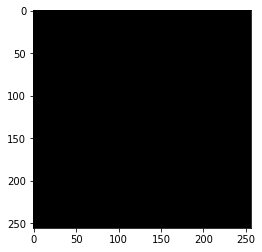

In [77]:
# play with numbers, see how changing the kernel affects the result
your_kernel = np.array([[0, 0, 0], 
                        [0, 0, 0], 
                        [0, 0, 0]])

c = convolve(gray_image, your_kernel)
print("Your kernel applied")
plt.imshow(c, cmap='gray')

some_kernel = np.array([[-1]])

Negative kernel applied


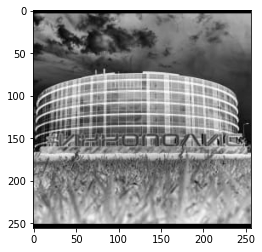

In [78]:
# Define the kernel that will result in reversed image, in which the lightest areas of
# the photographed subject appear darkest and the darkest areas appear the lightest.
negative_kernel = np.array([[-1]])

c = convolve(gray_image, negative_kernel)
print("Negative kernel applied")
plt.imshow(c, cmap='gray')

Blur kernel applied


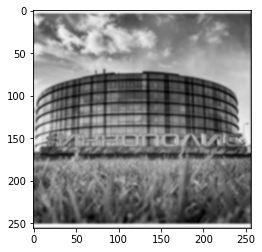

In [79]:
# Define the kernel that will result in a blurred image
# How can we control the degree of blur?
v1 = 0.5
v = 0.1
# this is an example of ~ gaussian blur
blur_kernel = np.array([[v, v, v, v, v], 
                        [v, v1, v1, v1, v],
                        [v, v1, 2, v1, v],
                        [v, v1, v1, v1, v],
                        [v, v, v, v, v]])

#simple sum
blur_kernel2 = np.ones((11,11))

c_blurred = convolve(gray_image, blur_kernel)
print("Blur kernel applied")
plt.imshow(c_blurred, cmap='gray')

Sharpen kernel applied


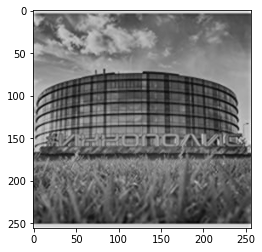

In [80]:
# Now let's sharpen the blurred image back 
sharpen_kernel = np.array([[0, -1, 0], 
                           [-1, 5, -1], 
                           [0, -1, 0]])

c = convolve(c_blurred, sharpen_kernel)
print("Sharpen kernel applied")
plt.imshow(c, cmap='gray')

## Applying the ANN on the  MNIST dataset

Let's  load the MNIST dataset again (since we made some changes on the previously loaded dataset).

In [29]:

(X_train_digit, y_train_digit), (X_test_digit, y_test_digit) = datasets.mnist.load_data()

X_train_digit = X_train_digit.reshape(60000, 784)
X_test_digit = X_test_digit.reshape(10000, 784)


#Encoding the Labels
y_train_digit = keras.utils.to_categorical(y_train_digit, num_classes=10)

y_test_digit = keras.utils.to_categorical(y_test_digit, num_classes=10)

Let's create ANN with the following architecture:

-> Dense ( where input=784 and with 128 units)

-> Dense with 24 units, with activation function relu

-> Dense with 24 units, with activation function relu

-> Dense with 10 units, with activation function sigmoid

In [30]:
#Creating base neural network
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(24, activation='relu'),
    layers.Dense(24, activation='relu'),
    layers.Dense(10,activation='sigmoid'),
])

2022-10-24 19:45:14.200596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
 dense_2 (Dense)             (None, 24)                600       
                                                                 
 dense_3 (Dense)             (None, 10)                250       
                                                                 
Total params: 104,426
Trainable params: 104,426
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics = ['accuracy'])

Let's train the ANN on the dataset.

In [33]:

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train_digit, y_train_digit, batch_size=100, epochs=20, validation_split=0.1)

Epoch 1/20
540/540 [==============================] - 2s 2ms/step - loss: 1.8904 - accuracy: 0.4946 - val_loss: 0.7838 - val_accuracy: 0.7673
Epoch 2/20
540/540 [==============================] - 1s 2ms/step - loss: 0.6247 - accuracy: 0.8237 - val_loss: 0.4428 - val_accuracy: 0.8890
Epoch 3/20
540/540 [==============================] - 1s 2ms/step - loss: 0.3657 - accuracy: 0.9059 - val_loss: 0.2947 - val_accuracy: 0.9247
Epoch 4/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2642 - accuracy: 0.9325 - val_loss: 0.2087 - val_accuracy: 0.9448
Epoch 5/20
540/540 [==============================] - 1s 2ms/step - loss: 0.2117 - accuracy: 0.9456 - val_loss: 0.1826 - val_accuracy: 0.9568
Epoch 6/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1705 - accuracy: 0.9557 - val_loss: 0.1638 - val_accuracy: 0.9592
Epoch 7/20
540/540 [==============================] - 1s 2ms/step - loss: 0.1547 - accuracy: 0.9587 - val_loss: 0.1593 - val_accuracy: 0.9607
Epoch 

Let's plot the diagram which shows the progress in loss of the model during the train:

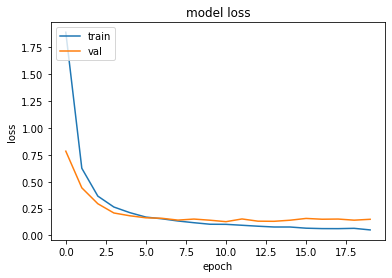

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We can also plot the diagram which shows the progress of the model with regard to its accuracy.

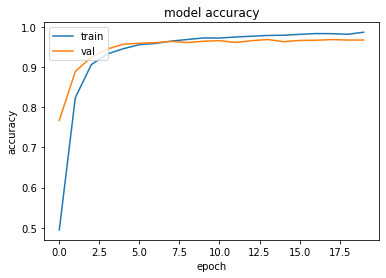

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate the trained model

In [36]:
score = model.evaluate(X_test_digit, y_test_digit, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1708669662475586
Test accuracy: 0.9649999737739563


As you can judge from the results, the ANN has around 104K params and we spent 20 epochs on achieving such an accuracy.

Now let's see how CNN could solve such problems easier.

## Building a CNN using PyTorch

First, let's import the torch library, and we will also try to set the device to GPU if available

In [1]:
import torch

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:

from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

### Get familiar with dataset

Train dataset info

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


Test dataset info

In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


Get familiar with the shapes of the dataset

In [6]:
print(f"train dataset shape: {train_data.data.size()}")
print(f"target shape: {train_data.targets.size()}")

train dataset shape: torch.Size([60000, 28, 28])
target shape: torch.Size([60000])


## Visualization of MNIST dataset

Let's plot one single data point

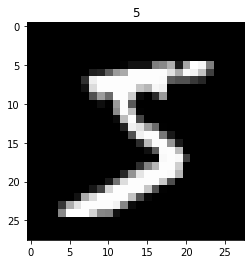

In [7]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

Now, let's plot multiple images

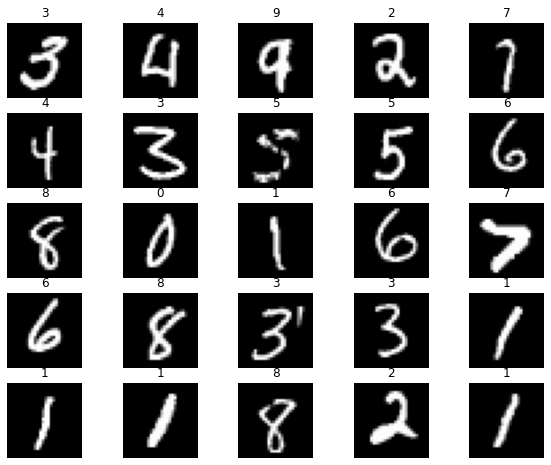

In [8]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Preparing data for training with DataLoaders

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [9]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fa21fd9cf70>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fa21fd9cdc0>}

## The modules / classes in torch for CNN

Conv2d: Applies a 2D convolution over an input signal composed of several input planes.

Parameters

- in_channels (int) — Number of channels in the input image

- out_channels (int) — Number of channels produced by the convolution

- kernel_size (int or tuple) — Size of the convolving kernel

- stride (int or tuple, optional) — Stride of the convolution. Default: 1

- padding (int or tuple, optional) — Zero-padding added to both sides of the input. Default: 0

- padding_mode (string, optional) — ‘zeros’, ‘reflect’, ‘replicate’ or ‘circular’. Default: ‘zeros’

- dilation (int or tuple, optional) — Spacing between kernel elements. Default: 1

- groups (int, optional) — Number of blocked connections from input channels to output channels. Default: 1

- bias (bool, optional) — If True, adds a learnable bias to the output. Default: True

In [10]:
import torch.nn as nn


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.conv1(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization


Commenting on the above mode:

- in_channels=1: because our input is a grayscale image.

- Stride: is the number of pixels to pass at a time when sliding the convolutional kernel.

- Padding: to preserve exactly the size of the input image, it is useful to add a zero padding on the border of the image.

- kernel_size: we need to define a kernel which is a small matrix of size 5 * 5. To perform the convolution operation, we just need to slide the kernel along the image horizontally and vertically and do the dot product of the kernel and the small portion of the image.

- The forward() pass defines the way we compute our output using the given layers and functions.

Now let's create the model based on the architecture specified in the above class:

In [11]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


### Let's define a loss function

In [12]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

### Optimization Function

Now we will define optimization Function

In [13]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### It's time to train the model!

Create a function called train() and pass num of epochs, model and data loaders as input parameters.

num_epochs: Number of times our model will go through the entire training dataset

In [16]:
from torch.autograd import Variable
num_epochs = 10


def train(num_epochs, cnn, loaders):

    cnn.train()

    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y

            output = cnn(b_x)[0]
            loss = loss_func(output, b_y)

            # clear gradients for this training step
            optimizer.zero_grad()

            # backpropagation, compute gradients
            loss.backward()
            # apply gradients
            optimizer.step()

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
train(num_epochs, cnn, loaders)


Epoch [1/4], Step [100/600], Loss: 0.0011
Epoch [1/4], Step [200/600], Loss: 0.1279
Epoch [1/4], Step [300/600], Loss: 0.0061
Epoch [1/4], Step [400/600], Loss: 0.0249
Epoch [1/4], Step [500/600], Loss: 0.0227
Epoch [1/4], Step [600/600], Loss: 0.0313
Epoch [2/4], Step [100/600], Loss: 0.0065
Epoch [2/4], Step [200/600], Loss: 0.0225
Epoch [2/4], Step [300/600], Loss: 0.2443
Epoch [2/4], Step [400/600], Loss: 0.0373
Epoch [2/4], Step [500/600], Loss: 0.0818
Epoch [2/4], Step [600/600], Loss: 0.0242
Epoch [3/4], Step [100/600], Loss: 0.0735
Epoch [3/4], Step [200/600], Loss: 0.0042
Epoch [3/4], Step [300/600], Loss: 0.0011
Epoch [3/4], Step [400/600], Loss: 0.0727
Epoch [3/4], Step [500/600], Loss: 0.0011
Epoch [3/4], Step [600/600], Loss: 0.0875
Epoch [4/4], Step [100/600], Loss: 0.0000
Epoch [4/4], Step [200/600], Loss: 0.0022
Epoch [4/4], Step [300/600], Loss: 0.0337
Epoch [4/4], Step [400/600], Loss: 0.0001
Epoch [4/4], Step [500/600], Loss: 0.0026
Epoch [4/4], Step [600/600], Loss:

### Evaluate the model on test data

We must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference.

model.train() tells your model that you are training the model. So effectively layers like dropout, batchnorm etc. which behave different on the train and test procedures know what is going on and hence can behave accordingly.

You can call either model.eval() or model.train(mode=False) to tell that you are testing the model.

In [25]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

test()

Test Accuracy of the model on the 10000 test images: 0.99


## Building a CNN using Keras in Tensorflow platform

First, we will load the required libraries. The keras library on top of the tensorflow will be utilized.

Keras and TensorFlow are both open-source software. TensorFlow is a software library for machine learning. Keras runs on top of TensorFlow and expands the capabilities of the base machine-learning software. Keras also makes implementation, testing, and usage more user-friendly.

Keras works with TensorFlow to provide an interface in the Python programming language. It works by using layers and models.

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
import numpy as np

### Dataset

We will be experimenting the CNN technique on the MNIST (http://yann.lecun.com/exdb/mnist/) dataset which has 60,000 and 10,000 rows for the train and test sets, respectively.

Using keras library, we can load the MNIST dataset directly from the datasets package.

In [38]:
(x_train, y_train), (x_test, y_test)=tf.keras.datasets.mnist.load_data()

In [39]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

Exploring the dataset is an important phase. So we will get familiar with different aspects of the dataset.

In [40]:
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)
x_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


Since most of the libraries and frameworks that work with image expect the input data to be in 4 dimension ($batch\_size \times height \times width \times channel\_for\_colors$) in order to support colored images as well, we should also add another dimension to our dataset to make it 4-dimensional dataset.

In [41]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
x_train.shape

(60000, 28, 28, 1)

Let's also get familiar with the labels.

In [42]:
y_train.shape

(60000,)

In [43]:
import pandas as pd
df_y_train = pd.DataFrame(y_train)
df_y_train.describe()

,0
count,60000.000000
mean,4.453933
std,2.889270
min,0.000000
25%,2.000000
50%,4.000000
75%,7.000000
max,9.000000


In [44]:
df_y_train.head()

,0
0,5
1,0
2,4
3,1
4,9


As you can see, the labels just digits from 0 to 9.

To get visualised information about the dataset, let's plot some of the elements. 
For that, we will create a function which will plot an image with its label (digit).

In [45]:
def plot_digits(X, Y):
    for i in range(20):
        plt.subplot(5, 4, i+1)
        plt.tight_layout()
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title('Digit: {}'.format(Y[i]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

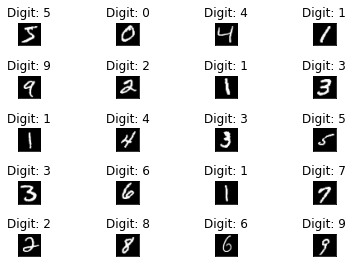

In [46]:
plot_digits(x_train, y_train)

Since the values of the dataset (x_train and x_test) lie between [0,255], we should normalize it.

In [47]:
# write two lines of code that will make the pixels lie between [0, 255]
x_train = x_train / 255.0
x_test = x_test / 255.0

Let's convert the labels into binary class matricies, since we saw earlier that the labels are just in digits format.

In [48]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Let's create the sequental model of the keras for adding the layers of the CNN one by one.

The Sequential model should have the following architecture:

-> Input with shape $[128 \times 128 \times 1]$

-> Conv2D (32 filters; kernel size is $[3 \times 3]$; activation function is relu ) 

-> MaxPooling2D layer with pool size $[2 \times 2]$

-> Conv2D (64 filters; kernel size is $[3 \times 3]$; activation function is relu ) 

-> MaxPooling2D layer with pool size $[2 \times 2]$

-> Flatten

-> Dense layer with the softmax activation function (you should also specify the number of output classes)

In [49]:
# implement the CNN model with the given architecture above
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 10)               

Let's start the training process.  Before that, we should config the model with losses and metrics with model.compile().

In [50]:
batch_size = 128
epochs = 5
# todo: write one line of code to compile the model with:
#   - the categorical_crossentropy loss function
#   - use adam as optimizer
#   - use 'accuracy' as metrics

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# todo: write one line of code to train the model:
#   - set the size of the batch size
#   - also, set train / validation dataset split as 90 / 10

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/5
422/422 [==============================] - 16s 37ms/step - loss: 0.2977 - accuracy: 0.9188 - val_loss: 0.0805 - val_accuracy: 0.9758
Epoch 2/5
422/422 [==============================] - 15s 36ms/step - loss: 0.0771 - accuracy: 0.9765 - val_loss: 0.0582 - val_accuracy: 0.9857
Epoch 3/5
422/422 [==============================] - 15s 36ms/step - loss: 0.0560 - accuracy: 0.9830 - val_loss: 0.0607 - val_accuracy: 0.9820
Epoch 4/5
422/422 [==============================] - 15s 36ms/step - loss: 0.0464 - accuracy: 0.9864 - val_loss: 0.0469 - val_accuracy: 0.9873
Epoch 5/5
422/422 [==============================] - 16s 37ms/step - loss: 0.0385 - accuracy: 0.9885 - val_loss: 0.0412 - val_accuracy: 0.9885


Let's plot the diagram which shows the progress in loss of the model during the train:

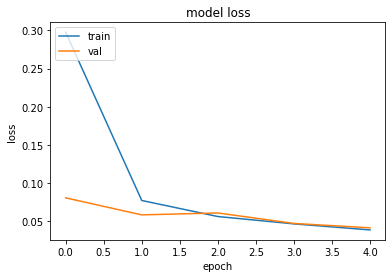

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We can also plot the diagram which shows the progress of the model with regard to its accuracy.

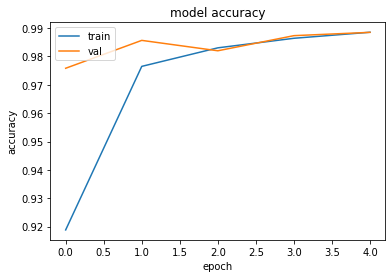

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate the trained model

In [53]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04094332456588745
Test accuracy: 0.9857000112533569


As you can judge from the results, the CNN achieved higher accuracy with less number of parameters (~ 32K) and in less epochs, while the ANN has around 104K params and we spent 20 epochs on achieving less accuracy.

References:

- https://phoenixnap.com/kb/how-to-install-keras-on-linux
- https://www.quora.com/What-is-the-meaning-of-a-filter-size-in-a-CNN
- https://stats.stackexchange.com/questions/363190/why-we-use-activation-function-after-convolution-layer-in-convolution-neural-net
- https://medium.com/analytics-vidhya/applying-ann-digit-and-fashion-mnist-13accfc44660
- https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118